<div>
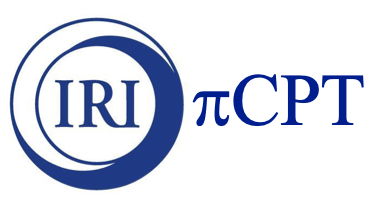
</div>

## s2sv1.5 (23 Nov 2019)
## Produce S2S (un)calibrated forecasts and assess associated skill 


#### Authors: 
Authors: ÁG Muñoz (agmunoz@iri.columbia.edu), AW Robertson (awr@iri.columbia.edu), T Turkington (NEA), SJ Mason 

#### Acknowledgements: 
Rémi Cousin (IRI, key Ingrid code), James Doss-Gollin (Columbia Water Center, original download Python functions).
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson). 

#### Version log
See version.log in Github

#### Workflow
<div>
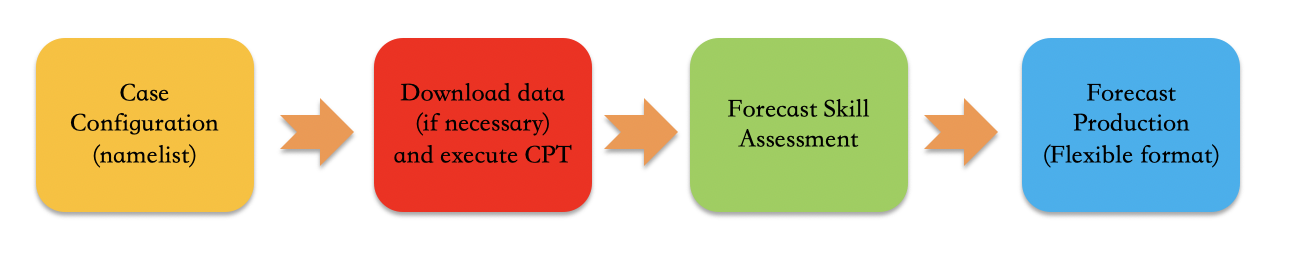
</div>

#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7), CHIRPS, CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* Probabilistic forecasts, in terciles and flex format.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is not deleted anymore at the beginning of the process, but scripts are!
2. Initializations available per month are used, concatenated.
3. The T coordinate has been faked, so CPT can deal with all the initializations.

### Namelist section
Here the user configures the case study

In [1]:
########Work name (name of the case/experiment, try one word)
work='IAS_s2s'

########Model (choose between ECMWF, CFSv2, GEFS)
model='ECMWFrt'

########Obs (choose between CHIRPS, TRMM, CPC, IMD1deg, IMDp25deg)
obs='CHIRPS'

########MOS method (choose between None, PCR, CCA and ELR)
MOS='None'

########Forecast date  
##-- If ECMWF, it needs to be a Monday or a Thursday! CFSv2: any day; GEFS: Wednesdays.
mon='Nov' 	# Forecast month 
fyr=2019 	# Forecast year
fday=25 	# Forecast day  (Yesterday in CFSv2: real time)
training_season='Oct-Dec' #only for CFSv2 and GEFS, use 3 months with the initialization as the middle one

nwk=4 # Number of weeks to process (leads)

########Switches:
force_download = False   #force download of data files, even if they already exist locally
# Rainfall frequency switch 
rainfall_frequency = False  #False gives total rainfall for forecast periods

wetday_threshold = 3 #WET day threshold (mm) --only used if rainfall_frequency is True!
threshold_pctle = False    #False for threshold in mm; Note that if True then if counts DRY days!!!

########Spatial domain for predictor
nla1=30 	# Northernmost latitude
sla1=-1 	# Southernmost latitude
wlo1=-120 	# Westernmost longitude
elo1=-45 	# Easternmost longitude
# Spatial domain for predictand
nla2=29 	# Northernmost latitude
sla2=0 	# Southernmost latitude
wlo2=-118 	# Westernmost longitude
elo2=-47 	# Easternmost longitude

########Forecast lead interval
# Lists for looping over lead times
wk = [1,2,3,4,34]  # week-lead number label (week1, week2, week3-4)
# ECMWF - first day is day 0, 0000Z accumulated rainfall; specify day1=0 for week 1
# GEFS - first day is day 0.5 (daily average rainfall rate); specify day1=0 for week 1
# CFSv2 - first day is day 1, 0000Z accumulated rainfall over the first day; specify day1=1 for week 1 
day1 = [0,7,14,21,14]  # first lead day of target weeks 
day2 = [7,14,21,28,28]  # last lead day of target weeks 
# 
wknam= ['Week 1','Week 2','Week 3','Week 4','Week 3-4']  #naming the weeks (for plots)

In [2]:
########Some folder and file options:
# Working directory --it should exist!!! (this is the place where the .py functions, notebooks, and .IRIDLAUTH is)
workdir = '/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/'
# PATH to CPT root directory
cptdir='/Users/agmunoz/Documents/Angel/CPT/CPT/16.2.4/'

########Naming of output files
if rainfall_frequency:
    fprefix = 'RFREQ'
else:
    fprefix = 'PRCP'

########Model-dependent parameters
if model=='CFSv2':
    hstep = 3 # use all starts in the trainng period with this daily step between them (v5 used 7)
    nlag  = 3  # length of the lagged ensemble in days
    ntrain= 363 # Length of training period
elif model=='ECMWF' or model=='ECMWFrt':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 160  # Length of training period
elif model=='GEFS':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 219  # Length of training period (for JJA, 1999-2015)   
else:
    print ("Model option is invalid")
    
########Observation dataset URLs
if obs == 'TRMM':
    obs_source = 'SOURCES/.NASA/.GES-DAAC/.TRMM_L3/.TRMM_3B42/.v7/.daily/.precipitation/X/0./1.5/360./GRID/Y/-50/1.5/50/GRID'
    hdate_last = 2014
elif obs == 'CPC':
    obs_source = 'SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/X/0./.5/360./GRID/Y/-90/.5/90/GRID'
    hdate_last = 2018
elif obs == 'CHIRPS':
    obs_source = 'SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/X/-180./.5/180./GRID/Y/-90/.5/90/GRID'
    hdate_last = 2018
elif obs == 'IMD1deg':
    obs_source = 'SOURCES/.IMD/.NCC1-2005/.v4p0/.rf'
    hdate_last = 2015
elif obs == 'IMDp25deg':
    obs_source = 'SOURCES/.IMD/.RF0p25/.gridded/.daily/.v1901-2015/.rf'
    hdate_last = 2016
else:
    print ("Obs option is invalid")
    
########MOS-dependent parameters
if MOS=='None':
    mpref='noMOS'
elif MOS=='CCA':
    mpref='CCA'
elif MOS=='PCR':
    mpref='PCR'
elif MOS=='ELR':
    mpref='ELRho'
#else:
#    print ("MOS option is invalid")

# S2S Database key
print("PyCPT folder is:")
%cd $workdir
!mkdir -p $work
with open(workdir+'.IRIDLAUTH') as file:
    authkey = file.read() 

PyCPT folder is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT


### End of namelist section

#### Load Libraries

In [3]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
print("Python libraries loaded")
print("Now in the work directory:")
%cd $work
workdir = os.getcwd()

Python libraries loaded
Now in the work directory:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_s2s


In [4]:
if rainfall_frequency:
    print('Predictand is Rainfall Frequency; wet day threshold = '+str(wetday_threshold)+' mm')
else:
    print('Predictand is Rainfall Total (mm)')

print("")
print("Creating input, output and script folders, if not already there...")
#print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p input/noMOS
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*

# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("")
print("CPT environment loaded. Using this CPT version:")
print(cptdir)

Predictand is Rainfall Total (mm)

Creating input, output and script folders, if not already there...
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_s2s

CPT environment loaded. Using this CPT version:
/Users/agmunoz/Documents/Angel/CPT/CPT/16.2.4/


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

Forecast date is 25 Nov 2019

   November 2019
Mo Tu We Th Fr Sa Su
             1  2  3
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
18 19 20 21 22 23 24
25 26 27 28 29 30

   December 2019
Mo Tu We Th Fr Sa Su
                   1
 2  3  4  5  6  7  8
 9 10 11 12 13 14 15
16 17 18 19 20 21 22
23 24 25 26 27 28 29
30 31



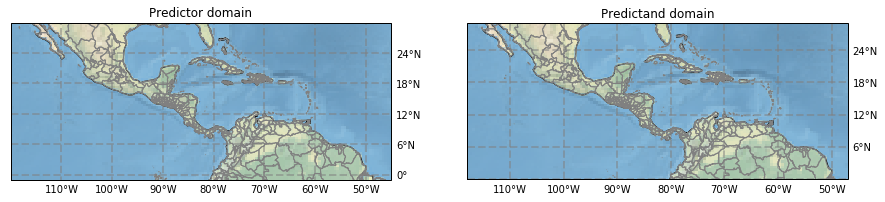

In [11]:
#Print calendars
print('Forecast date is '+str(fday)+' '+mon+' '+str(fyr))
print('')
c=calendar.TextCalendar(calendar.MONDAY)
print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)))
if list(calendar.month_abbr).index(mon)+1==13:
    print(c.formatmonth(fyr+1,1))
else:
    print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)+1))

#Plot domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2)

# Download data if necessary, and run CPT
This is the core section of PyCPT, in charge of downloading data and running the skill assessment and forecast sections of the job. This section typically takes some time to be executed.  

In [5]:
for L in range(nwk):
   nday=day2[L]-day1[L]	# Length of target period (days) 
   print("New folder:")
   %cd $workdir/input

   PrepFiles(rainfall_frequency,threshold_pctle, wlo1, wlo2,elo1, elo2,sla1, sla2,nla1, nla2, day1[L], day2[L], fday, nday, fyr, mon, os, authkey, wk[L], wetday_threshold, nlag, training_season, hstep, model, obs_source, hdate_last, force_download)
 
   print("New folder:")
   %cd $workdir/scripts

   CPTscript(mon,fday,wk[L],nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,training_season,ntrain,rainfall_frequency,MOS)

   print('Executing CPT for Week '+str(wk[L])+'... This might take a while... (want to grab a tea or a coffee?)')
   try:
        subprocess.check_output(cptdir+'CPT.x < params > CPT_log_'+training_season+'_ini'+mon+str(fday)+'_'+str(fyr)+'_wk'+str(wk[L])+'.txt',stderr=subprocess.STDOUT, shell=True)
   except subprocess.CalledProcessError as e:
        print(e.output.decode())
        raise
   print('\033[1m----------------------------------------------\033[0;0m')
   print('\033[1mWeek '+str(wk[L])+' calculations completed!\033[0;0m')
   print('\033[1mSee output folder, and check scripts/CPT_log_'+training_season+'_ini'+mon+str(fday)+'_'+str(fyr)+'_wk'+str(wk[L])+'.txt for log\033[0;0m')
   print('\033[1mQuick error report from CPT (if any):\033[0;0m')
   with open('CPT_log_'+training_season+'_ini'+mon+str(fday)+'_'+str(fyr)+'_wk'+str(wk[L])+'.txt', "r") as fp:
        for line in lines_that_contain("Error:", fp):
            print (line)
   print('\033[1m----------------------------------------------\033[0;0m')
   print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')

New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_s2s/input
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------

 Short hindcast file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 82500    0 82500    0     0  17390      0 --:--:--  0:00:04 --:--:-- 17390
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_s2s/scripts
Executing CPT for Week 1... This might take a while... (want to grab a tea or a coffee?)
----------------------------------------------
Week 1 calculations completed!
See output folder, and check scripts/CPT_stout_train_Oct-Dec_iniNov25_2019_wk1.txt for log
Quick error report from CPT (if any):
 Error:  Problem performing GCM

------

## Skill maps
Now that everything has been computed and all files are saved, this section plots deterministic and probabilistic skill maps.

New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_s2s/output


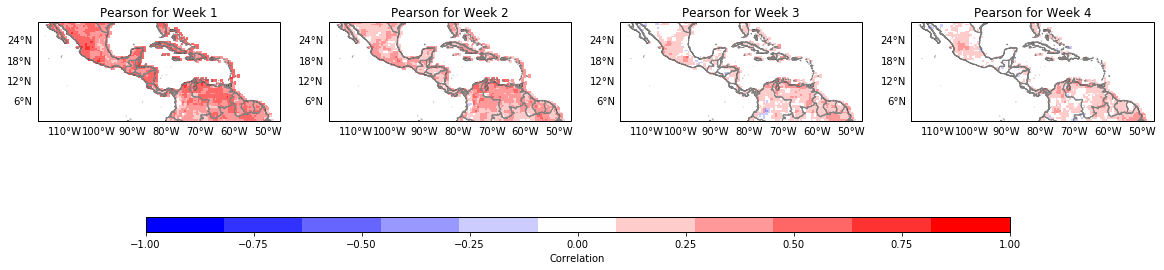

----------------------------------------------



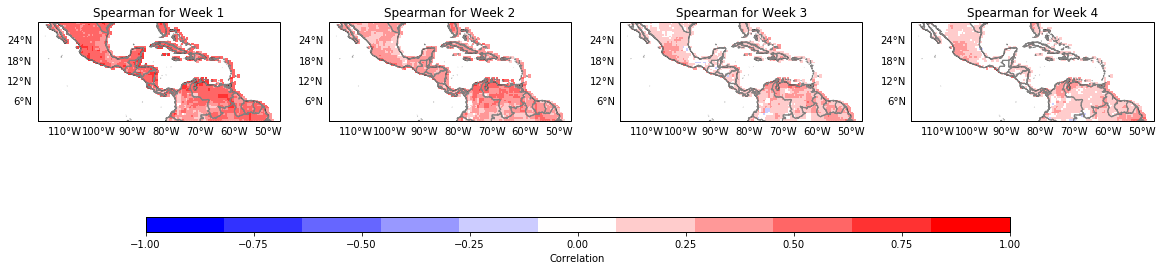

----------------------------------------------



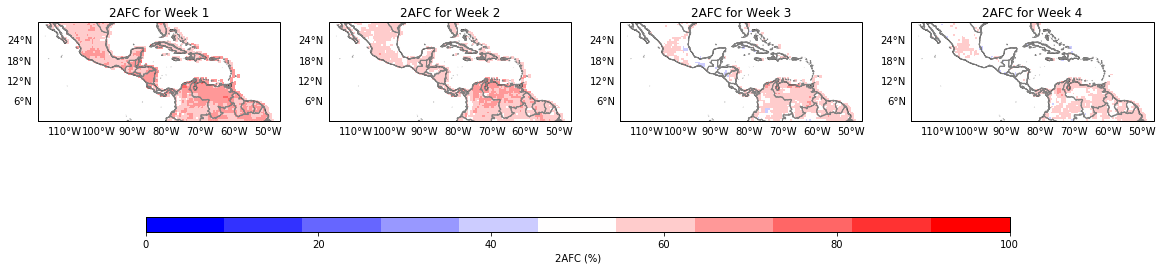

----------------------------------------------



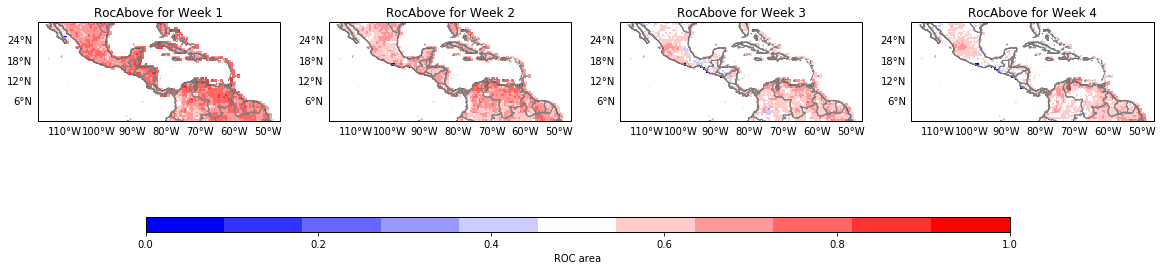

----------------------------------------------



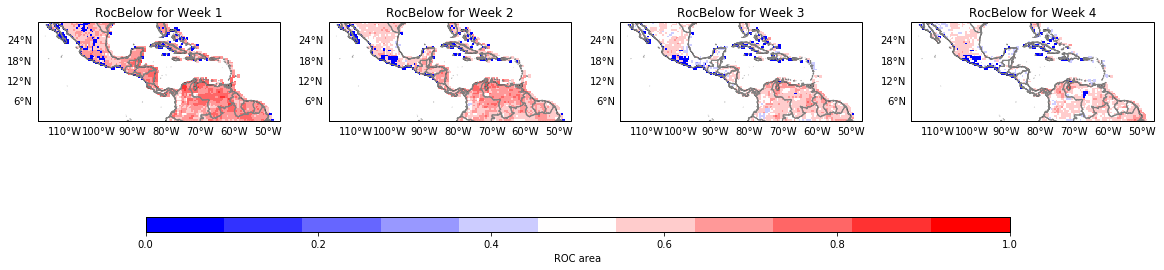

----------------------------------------------



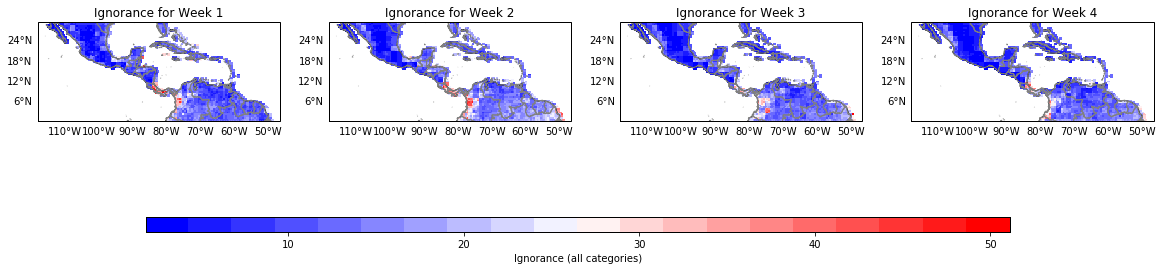

----------------------------------------------



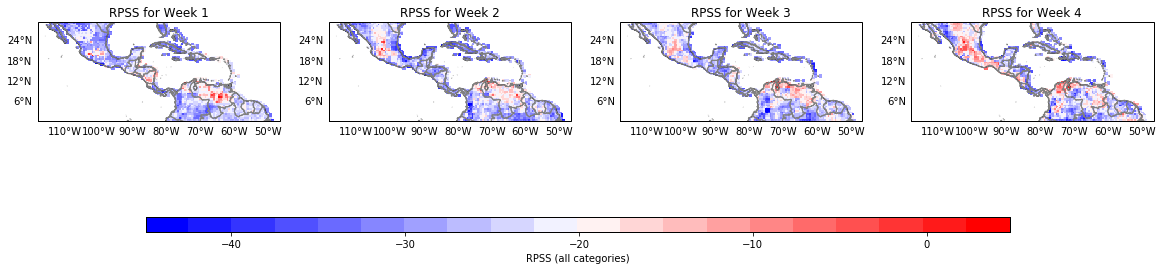

----------------------------------------------



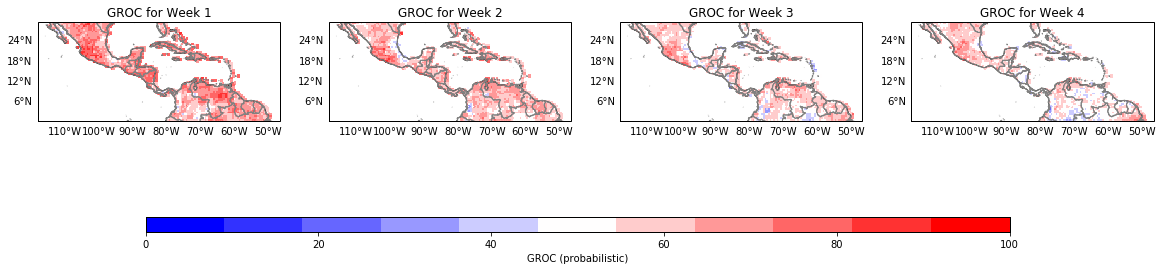

----------------------------------------------




PROCESS COMPLETED 


In [28]:
print("New folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 10})
for ime in ('Pearson','Spearman','2AFC','RocAbove','RocBelow','Ignorance','RPSS','GROC'):
    pltmap(ime,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk) 
    plt.savefig(('Skill_' + ime + '.pdf'), dpi=300)
    plt.show()
    print('----------------------------------------------')
    print('')
    
print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')

### Regional summary (table)

In [19]:
print("Folder:")
%cd $workdir/output

#Desired scores: 
score=('Spearman','2AFC','RocAbove','RocBelow','Ignorance','RPSS','GROC')
#Coordinates of the box:
lon1=-105 #lon of upper left point of geographical sub-domain
lat1=24  #lat of upper left point of geographical sub-domain
lon2=-100 #lon of lower right point of geographical sub-domain
lat2=18  #lat of lower right point of geographical sub-domain
# Skill scores loop
df=skilltab(score,wknam,lon1,lat1,lat2,lon2,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk)
df

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_s2s/output


,Spearman,max(Spearman),min(Spearman),2AFC,max(2AFC),min(2AFC),RocAbove,max(RocAbove),min(RocAbove),RocBelow,...,min(RocBelow),Ignorance,max(Ignorance),min(Ignorance),RPSS,max(RPSS),min(RPSS),GROC,max(GROC),min(GROC)
Week 1,0.32,0.60,0.07,60.099998,67.559998,50.709999,0.67,0.81,0.51,0.46,...,0.0,1.68,1.84,1.55,-3.09,-0.44,-6.42,54.750000,65.570000,41.919998
Week 2,0.19,0.48,-0.01,56.490002,63.049999,49.900002,0.59,0.70,0.46,0.47,...,0.0,1.63,1.80,1.44,-1.42,5.51,-5.44,54.930000,69.160004,40.790001
Week 3,0.21,0.39,-0.04,56.020000,61.869999,48.410000,0.61,0.72,0.50,0.51,...,0.0,1.61,1.74,1.48,-0.55,5.99,-3.78,56.709999,72.879997,39.599998
Week 4,0.28,0.43,-0.00,58.509998,64.110001,49.520000,0.64,0.78,0.50,0.53,...,0.0,1.65,1.80,1.48,-1.90,5.24,-5.32,57.630001,69.589996,44.180000


## Forecast maps
Finally, this section deals with plotting deterministic and probabilistic forecasts.

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_s2s/output
----------------------------------------------



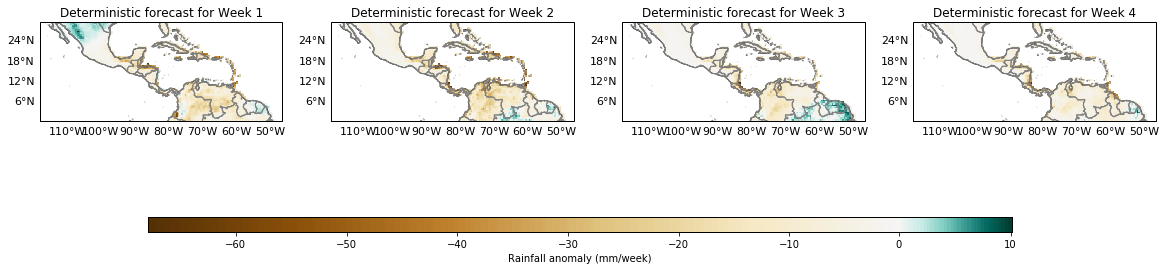

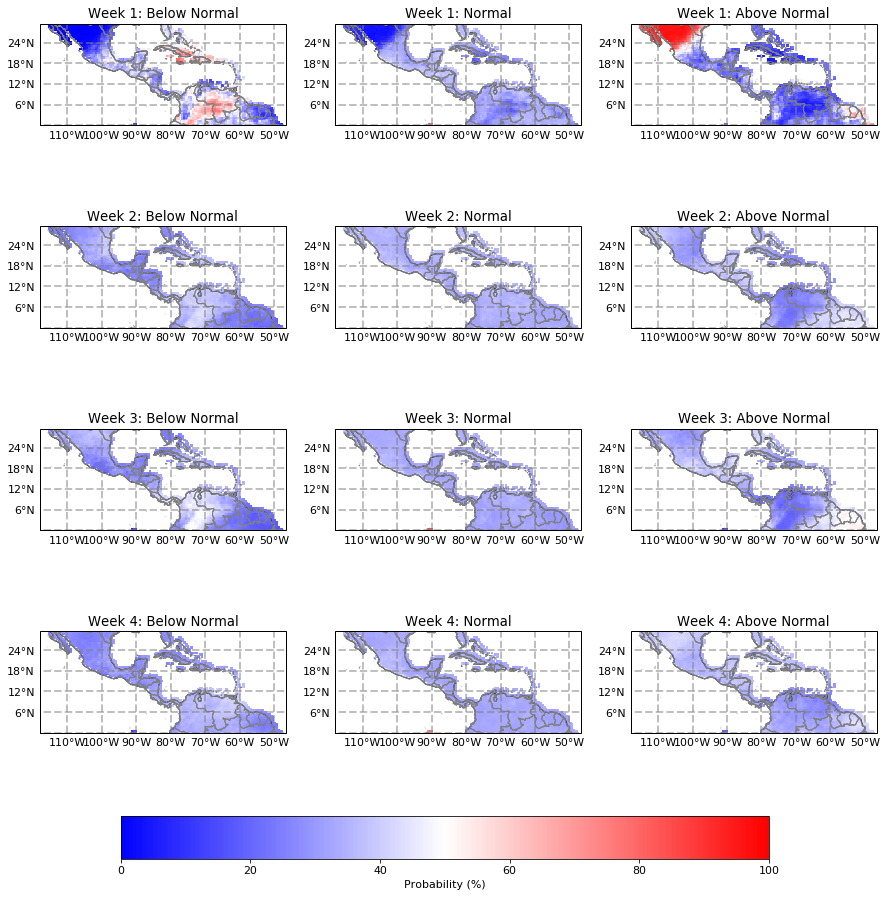

In [20]:
print("Folder:")
%cd $workdir/output

plt.rcParams.update({'font.size': 10})
pltmap(mpref+'FCST_V',wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk)
print('----------------------------------------------')
print('')
plt.rcParams.update({'font.size': 11})
pltmapProb(wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk)
plt.savefig("ProbFcst.pdf", dpi=300)

### Flexible Forecasts
The user can choose between acual physical thresholds or percentiles, and those can be the same or different for different target weeks.

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_s2s/output


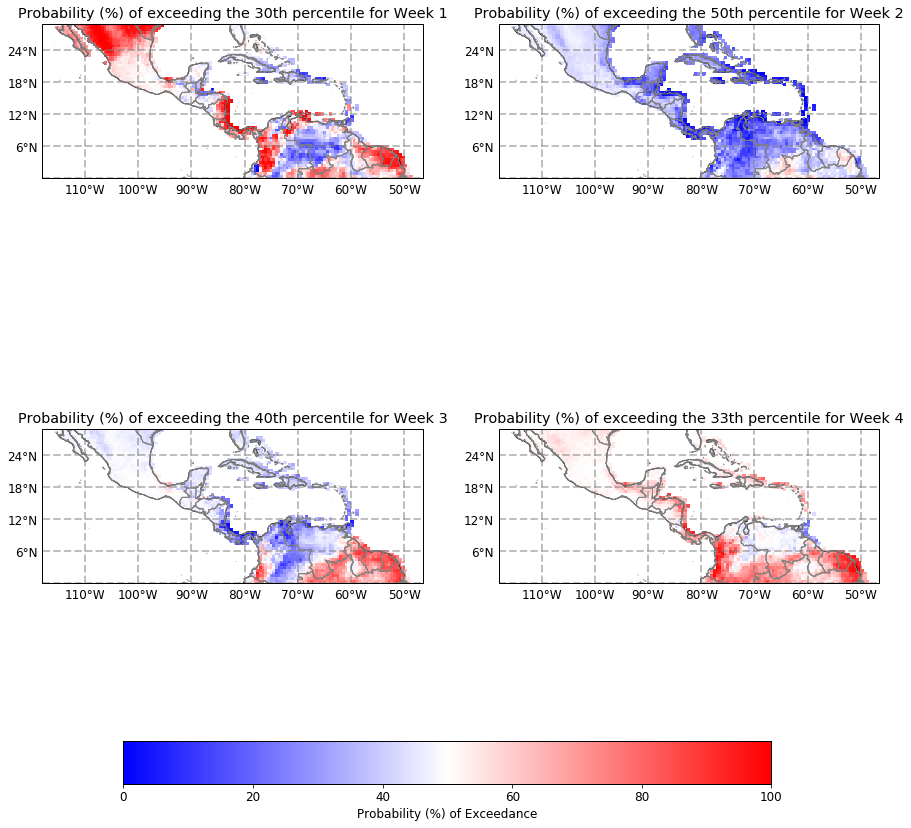

In [21]:
#threshold for the flexible format map (in mm/week -- remember: fcsts are in ANOMALIES!):
flexformat_threshold = [0.3,0.5,0.4,0.33] #array (we need one threshold per forecast week)
ffthres_ispctl=True  #If True, flex format threshold is a percentile: 0.001 - 0.999

print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
if mpref=='noMOS' and fprefix=='PRCP':
    pltmapff(flexformat_threshold,ffthres_ispctl,ntrain,wlo1,elo1,sla1,nla1,fprefix,mpref,training_season,mon,fday,nwk)
else:
    pltmapff(flexformat_threshold,ffthres_ispctl,ntrain,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk)
plt.savefig("ProbFcst_Flex.pdf", dpi=300)

#### Flexible forecasts for a particular location
Select a location in the map and write down the coordinates in this section to visualize the probability density functions, probabilities of exceedances (and flexible verification --coming soon).

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_s2s/output


<Figure size 1080x1080 with 0 Axes>

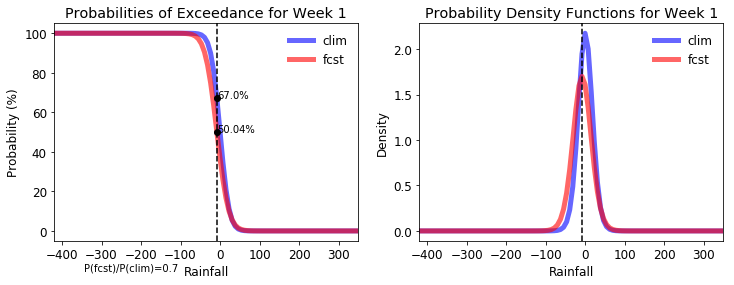

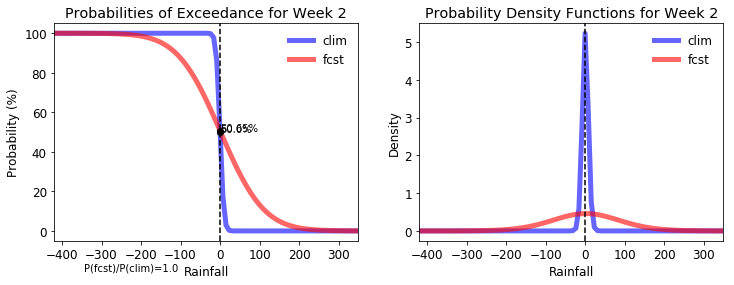

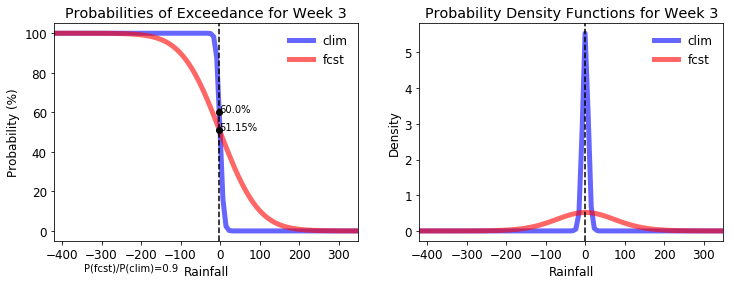

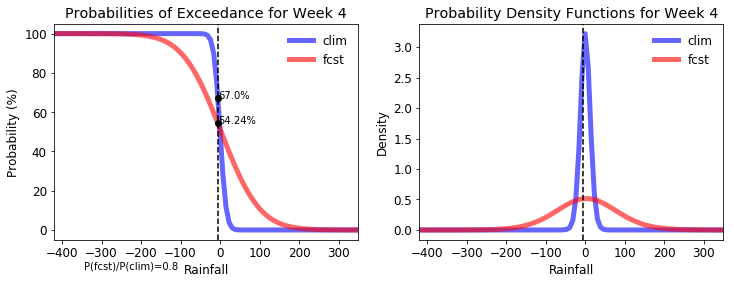

In [29]:
#threshold for the flexible format map (in mm/week -- remember: fcsts are in ANOMALIES!):
flexformat_threshold = [0.33,0.5,0.4,0.33] #array (we need one threshold per week to forecast)
ffthres_ispctl=True  #If True, flex format threshold is a percentile: 0.001 - 0.999
#Location coordinates:
lon=-90.
lat=15.
 
print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltprobff(flexformat_threshold,ffthres_ispctl,ntrain,lon,lat,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk)
plt.savefig("ProbExceed.pdf", dpi=300)